In [14]:
from pathlib import Path
from datasets import load_dataset, concatenate_datasets
from transformers import AutoTokenizer
from collections import Counter
from typing import List
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy.stats import pearsonr, linregress
from scipy.spatial.distance import pdist, cdist, dice, hamming, jaccard
import matplotlib.pyplot as plt
from data import preprocess_topical_chat_dataset, preprocess_function, load_data, prepare_data_for_model

In [2]:
tokenizer = AutoTokenizer.from_pretrained('resources/models/seed_23/pt/hf_conv/bart_small-SI_t5/')

In [3]:
def load_json_dataset(dataset: Path):   
    split = dataset.stem
    extension = dataset.suffix.strip('.')
    print(split, extension, str(dataset))
    dataset_dict = load_dataset(extension, data_files={'test': str(dataset)})
    return dataset_dict # concatenate_datasets(loaded_datasets)

def tokenize_dataset(dataset):
    dataset = dataset.map(
    preprocess_topical_chat_dataset,
    batched=True,
    num_proc=4,
    desc="Running tokenizer on dataset",
    fn_kwargs={
        'tokenizer': tokenizer,
        'speaker_id_tag': '<speaker_1>',
        'text_column': 'turns',
        'summary_column': 'target',
        'knowledge_column': 'knowledge',
        'knowledge_bucket_size': 32,
        'history_bucket_size': 25,
        'max_target_length': 128,
        'source_prefix': None,
        'pad_to_max_length': False,
        'ignore_pad_token_for_loss': False,
        },
    )
    
    return dataset

def flatten(l: List[List]) -> List:
    """flattens a list of lists"""
    return [item for sublist in l for item in sublist]

def get_vocab_stats(dataset, tokenizer=tokenizer):
    inputs_tokenized = list(map(tokenizer.convert_ids_to_tokens, dataset['test']['input_ids']))
    targets_tokenized = list(map(tokenizer.convert_ids_to_tokens, dataset['test']['labels']))

    print('inputs:')
    print(inputs_tokenized[:2], '...')
    print('targets:')
    print(targets_tokenized[:2], '...')

    input_vocab = Counter(flatten(inputs_tokenized))
    target_vocab = Counter(flatten(targets_tokenized))
    total_vocab = input_vocab + target_vocab

    print(f'Input vocab items: {len(input_vocab)}')
    print(f'Target vocab items: {len(target_vocab)}')
    print(f'Combined vocab items: {len(total_vocab)}')
    print(f'Most common tokens: {total_vocab.most_common(20)}')

    df = pd.DataFrame.from_dict(total_vocab, orient='index').reset_index()
    df = df.rename(columns={'index':'token', 0:'freq_count'})
    
    return df


In [6]:
# dataset = load_json_dataset(Path('resources/data/Topical-Chat/KGD/test_rare.json'))
# print(dataset)
# dataset = tokenize_dataset(dataset)
# df_rare = get_vocab_stats(dataset)
# df_rare.plot(logy=True)

In [7]:
# dataset = load_json_dataset(Path('resources/data/Topical-Chat/KGD/test_freq.json'))
# dataset = tokenize_dataset(dataset)
# df_freq = get_vocab_stats(dataset)
# df_freq.plot(logy=True)

In [8]:
dataset = load_json_dataset(Path('resources/data/Topical-Chat/KGD/train.json'))
print(dataset)

train json resources/data/Topical-Chat/KGD/train.json


Using custom data configuration default-9eea7701c7958c3c
Reusing dataset json (/home/cluster/tkew/.cache/huggingface/datasets/json/default-9eea7701c7958c3c/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['turns', 'knowledge', 'target'],
        num_rows: 145238
    })
})


In [9]:
print(len(dataset['test']))
print(type(dataset['test']))
print(dir(dataset['test']))

145238
<class 'datasets.arrow_dataset.Dataset'>
['_TF_DATASET_REFS', '__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_build_local_temp_path', '_check_index_is_initialized', '_data', '_fingerprint', '_format_columns', '_format_kwargs', '_format_type', '_get_cache_file_path', '_get_output_signature', '_getitem', '_indexes', '_indices', '_info', '_iter', '_map_single', '_new_dataset_with_indices', '_output_all_columns', '_push_parquet_shards_to_hub', '_select_contiguous', '_select_with_indices_mapping', '_split', 'add_column', 'add_elasticsearch_index', 'add_faiss_index', 'add_faiss_index_from_external_arrays', 'add_item', '

In [11]:
def is_question(text):
    if isinstance(text, list):
        return sum(list(map(is_question, text)))
    if '?' in text:
        return 1
    else:
        return 0

src_qus = np.array(list(map(is_question, dataset['test']['turns'])))
src_qus_ind = np.int64(src_qus > 0)
tgt_qus = np.array(list(map(is_question, dataset['test']['target'])))

In [94]:
print(pearsonr(src_qus,tgt_qus))
print(pearsonr(src_qus_ind,tgt_qus))

PearsonRResult(statistic=0.09551351159407137, pvalue=2.032077577753429e-291)
PearsonRResult(statistic=0.07832829958475114, pvalue=2.1735134661694424e-196)


In [22]:
print(dice(src_qus_ind,tgt_qus))
print(hamming(src_qus_ind,tgt_qus))
print(jaccard(src_qus_ind,tgt_qus))
print(jaccard(src_qus,tgt_qus))

0.5762186421770825
0.611726958509481
0.7311404988602418
0.9020383979196327


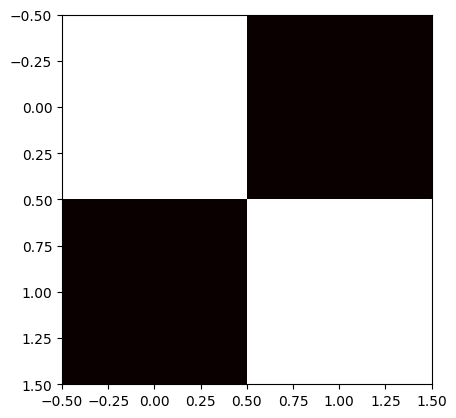

In [116]:
plt.imshow(np.corrcoef(src_qus,tgt_qus), cmap='hot', interpolation='nearest')

In [20]:
df = pd.DataFrame({'src': src_qus, 'tgt': tgt_qus})

In [21]:
df

,src,tgt
0,1,0
1,0,1
2,1,0
3,1,1
4,2,0
...,...,...
145233,1,0
145234,1,0
145235,1,1
145236,2,0


In [118]:
printdf['src'].corr(df['tgt'], method='spearman'))

0.09580578162897338

In [111]:
print(df['src'].describe())
print(df['tgt'].describe())

count    145238.000000
mean          1.506155
std           1.111722
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           5.000000
Name: src, dtype: float64
count    145238.000000
mean          0.264876
std           0.441268
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: tgt, dtype: float64


In [112]:
df['tgt'].sum()

38470

Regression line: y=0.21+0.04x, r=0.10


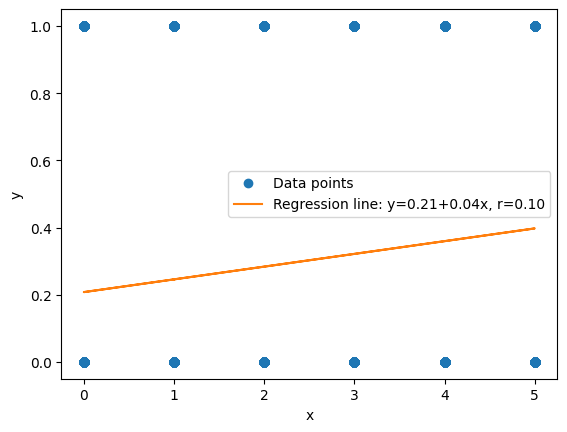

In [105]:
def plot(x, y):
    slope, intercept, r, p, stderr = linregress(x, y)
    line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
    print(line)
    fig, ax = plt.subplots()
    ax.plot(x, y, linewidth=0, marker='o', label='Data points')
    ax.plot(x, intercept + slope * x, label=line)
    ax.set_xlabel('x')
    
    ax.set_ylabel('y')
    ax.legend(facecolor='white')
    
    # ax.set_xlim(min(x), max(x))
    # ax.set_ylim(min(y), max(y))
        
    plt.show()

plot(src_qus,tgt_qus)

# plot(src_qus_ind,tgt_qus)

In [78]:
print(src_qus.shape)
print(src_qus.mean())
print(src_qus)

(145238,)
1.5061554138724025


AttributeError: 'numpy.ndarray' object has no attribute 'mode'

In [75]:
print(tgt_qus)

[0 1 0 ... 1 0 0]
